# Python notebook for case-study run on the CICIDS security dataset, by William Bridges (part of BSc dissertation work)

## Code set-up: Imports, Packages, Environment variables, and Methods

The software versions used are:
- The Python3 version used for this work is: Python 3.8.x
- The scikit-learn version used is: scikit-learn 0.24.0
- The seaborn version used is: 0.11.1
- The Pandas version used is: 1.1.5 (although 1.2.0 was released recently, this should also work)

Before running, please run these commands via pip, in the terminal:
- pip install pandas
- pip install scikit-learn
- pip install scikit-plot
- pip install seaborn

## Imports

In [1]:
%matplotlib inline
import os, sys # For accessing Python Modules in the System Path (for accessing the Statistical Measures modules)
# See: https://stackoverflow.com/a/39311677
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

import pandas as pd # For DataFrames, Series, and reading csv data in.
import seaborn as sns # Graphing, built ontop of MatPlot for ease-of-use and nicer diagrams.
import matplotlib.pyplot as plt # MatPlotLib for graphing data visually. Seaborn more likely to be used.
import numpy as np # For manipulating arrays and changing data into correct formats for certain libraries
import sklearn # For Machine Learning algorithms
import scikitplot # Confusion matrix plotting
from sklearn.decomposition import PCA # For PCA dimensionality reduction technique
from sklearn.preprocessing import StandardScaler # For scaling to unit scale, before PCA application
from sklearn.preprocessing import LabelBinarizer # For converting categorical data into numeric, for modeling stage
from sklearn.model_selection import StratifiedKFold # For optimal train_test splitting, for model input data
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors ML classifier (default n. of neighbors = 5)
from scikitplot.metrics import plot_confusion_matrix # For plotting confusion matrices
from sklearn.metrics import accuracy_score # For getting the accuracy of a model's predictions
from sklearn.metrics import classification_report # Various metrics for model performance
from sklearn.neural_network import MLPClassifier # For Neural Network classifier

## Methods

**Clean_dataset()** method is used to remove infinite and Nan value errors (in the original dataset), which was causing errors in the PCA transform step.

- **assert** keyword can be used for testing purposes. If the input param is not of type Pandas Dataframe, then the error message will be shown. Thus, you 'assert' that a pd.Dataframe is input.


- **.dropna(inplace=True)** drops any rows which contain NaN/ Null values. NaN values would cause issues later on, with model training and other functions. A lot of functions require NaN values to be removed to work (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).

Code reference: https://stackoverflow.com/a/46581125 (with a minor change = removed the conversion to float64 type)

In [2]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

**get_PCA_feature_names()** method is used to generate feature names for the number of PCA components passed in as a param. Returns a list of feature names for principal component column headings, in a Pandas Dataframe.

- No special code here, just pure Python code. Instantiating a list, and populating it with strings for the PCA header names. Then, appending each to the list and returning it.

In [3]:
def get_PCA_feature_names(num_of_pca_components):
    feature_names = []
    for i in range(num_of_pca_components):    
        feature_names.append(f"Principal component {i+1}")
    return feature_names

**train_model_predict()** method is used to train an input model, using StratifiedFKold for train_test splitting, and uses the trained model to predict the test data. It outputs a classification report which has various useful prediction metrics displayed. It also outputs a confusion matrix for the model's predictions. Finally, it returns the accuracy of the model's predictions.

- 1) The for loop ('for train_index, test_index in skf.split(X, y):') is required as it uses the indexes that the  StratifiedKFold model (**skf**) produces to select the appropriate data rows/ points required for each data split.


- 2) The 'X_train, X_test = X.iloc[train_index], X.iloc[test_index]' uses the skf indexes to find the index location (iloc) of each index, so it can extract the correct rows for the train_test split.


- 3) The 'reshaped_y_train = np.asarray(y_train).reshape(-1, 1)' is required to reshape the label (y_train and y_test) to a 1D array, rather than a 2D array that is output by the train_test split.


- 4) The 'model.fit(X_train, reshaped_y_train.ravel())' uses the input model and fits it (trains the model) on the training data. The '.ravel()' method just reshapes the label array again (flattens it) to match the input structure required by the sklearn method.


- 5) The 'pred_y = model.predict(X_test)' uses the, now trained, model to attempt to predict the test data (X_test is passed in, and it predicts the label, pred_y).


- 6) The 'score = classification_report(reshaped_y_test, pred_y)' calculates prediction metrics based upon the model's predictions. More info in the docs: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

The rest is self-explanatory. A confusion matrix is plotted and output after the method runs. The accuracy of the model is returned back to the caller, as well as other data required for the statistical distance measure methods.

In [4]:
# See documentation above to understand what each step does, and why.
def train_model_predict(model, model_name, X, y, skf):
    for train_index, test_index in skf.split(X, y): # 1)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] # 2)
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reshaped_y_train = np.asarray(y_train).reshape(-1, 1) # 3)
        reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    model.fit(X_train, reshaped_y_train.ravel()) # 4)
    pred_y = model.predict(X_test) # 5)
    score = classification_report(reshaped_y_test, pred_y) # 6)
    print('Classification report: \n', score, '\n')
    plot_confusion_matrix(reshaped_y_test, pred_y, title='Confusion Matrix for {}'.format(model_name))
        
    return accuracy_score(reshaped_y_test, pred_y), X_train, X_test, y_train, pred_y

**get_shuffled_stratifiedKFold_train_test_split()** method is for retrieving shuffled, StratifiedKFold train test split data. It's similar to the 'train_model_predict()' method above- see this for details behind each step/ line of code. This is industry-standard for dealing with datasets which have a large class imbalance, such as this one.

The method takes in X (dataset without the labels/ classes) and y (the label/ class feature). It instantiates a new StratifiedKFold 'model' which comes from the 'sklearn.model_selection' library. The **n_splits** parameter denotes how many folds (K) are to be run. The **Shuffle** parameter denotes that each split will be shuffled and therefore randomized to get varying shuffles between runs. This is ideal, as each permutation to be run should be as varied as possible to give good variance in plotting- so the SafeML idea can be showcased & plotted optimally.

The for loop uses the StratifiedKFold 'model' to extract indices that have been found by the skf model. The label/ class feature needs to be reshaped in SkLearn, as un-shaped label data causes exceptions/ errors when attempting to train, predict, or use any SkLearn ML classifiers/ models.

Finally, all the extracted data is returned.

See docs here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [ ]:
def get_shuffled_stratifiedKFold_train_test_split(X, y):
    # Shuffle to True, to get different shuffles each time. Permutations being varied is the goal here.
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    
    # For loop to get index for training and test data, using StratifiedKFold (3 splits)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Reshape needed for label, so that the model can use it (required in SciKit Learn)
        reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
        reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    # After for loop ends, all training and test data has been retrieved thus can return it.
    return X_train, X_test, y_train, y_test

#### Neural Networks (MLP), quick explanation/ clarification
Neural Networks, and specifically the sklearn Multi-Layer Perceptron (MLPClassifier), aims to model the brain's neurons and its inner workings. 

A set of input values and weights are evaluated, and passed into the first layer of the neural network. The neural network can have multiple layers, with a varied amount of nodes (via hyperparameters) in each layer. 

Hyperparameters are the parameters of the model that- if changed- affect the learning rate and prediction accuracy.

If an input weight, X, along with a learning rate, Y, evaluates to a value above a given **threshold** (like a neuron's Potassium & Sodium based Action Potential threshold), then just like a real neuron, the neuron will fire and send information to the next node in the layer, or possibly the output node. 

The output node will take all of the processed information, from all the nodes in each interconnected (fully-connected MLP) layer, and a classification result will be given.

The inner workings of large Neural Nets are still un-explainable (as of March 2021), which is why they're referred to as a **Black-box classifier/ model**.

This is how a Neural Network learns and predicts a label/ class based on input data. The methods by which learning occurs (Backpropagation, Momentum, Learning rate input, Weight adjustments, etc...) is beyond the scope of this solution.

From docs: "Multi-layer Perceptron classifier. This model optimizes the log-loss function using LBFGS or stochastic gradient descent".

Important note from the default MLP params, from the docs: 
- "Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better". 

###### So the 'lbfgs solver' hyperparameter may not be ideal for this larger dataset. Thus, the 'Adam solver' will be used. 

(Code references: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

#### Finding the optimal Neural Network hyperparameters is hard
"So what about size of the hidden layer(s)--how many neurons? There are some empirically-derived rules-of-thumb, of these, the most commonly relied on is 'the optimal size of the hidden layer is usually between the size of the input and size of the output layers" by Jeff Heaton (https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw). As per the reference, a low amount of nodes in the hidden layer can be ideal for a particular dataset. 

Input size is around 30 PCA component features, with 1 output node (for the label). Therefore between 10 and 20 nodes, with 1 hidden layer, would be following these heuristics. It can be incredibly hard to train and larger Neural Network correctly, although it has been proved- theoretically- that a Neural Network can solve any task, as long as it's large enough and has the correct hyperparameter tuning. This is an NP-hard problems though.

See docs: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

**train_and_predict_Neural_Network_MLP_model()** method trains a Neural Network (MLP) classifier and uses this to predict the labels of the X_test data. See more in-depth information about Neural Networks above^^^. For in-depth info on the hyperparameter tuning in SciKit (will be similar to TensorFlow & Keras, PyTorch, FastAI, and any other ML library), see below...

**Hyperparameter explanations:**
- **activiation=** ReLu is an industry-standard activation function "rectified linear unit function, f(x) = max(0, x)" (SciKit docs)
- **hidden_layer_sizes=** (15,) means 1 hidden layer with 15 nodes in
- **solver=** Adam solver works efficiently on large datasets, and is the "stochastic gradient-based optimizer" (SciKit docs)
- **alpha=** is a penalty (regularization term) parameter
- **batch_size=** refers to the size of mini-batches for stochastic optimizers. If the solver is ‘lbfgs’, the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)
- **learning_rate=** is the "learning rate schedule for weight updates". Setting as 'constant' would keep the learning rate the same as the learning_rate_init value, even if two epochs were to not decrease by at least 'tol', which is not ideal. Thus, an 'adaptive' learning rate is used and this "keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5" (SciKit docs)
- **learning_rate_init=** is just the initial learning rate value. It "controls the step-size in updating the weights".
- **max_iter=** refers to the maximum number of iterations the MLP classifier will run through (each iteration/ epoch updates the node weights in accordance to other hyperparam info e.g. activation function, alpha, learning rate, etc... This is to try and increase the predictive capability of the MLP model). SciKit docs state "For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps". Although, the more iterations, the longer the training takes. After a certain threshold, more iterations will not improve the predictive capability of the MLP model.

Note: Could add if statement to print out confusion matrix x amount of times, during this method.

In [2]:
def train_and_predict_Neural_Network_MLP_model(X_train, X_test, y_train, y_test):
    # Instantiating new Neural Network classifier and setting Hyperparameters
    Neural_Net_model = MLPClassifier(hidden_layer_sizes=(15,), activation='relu',
                                    solver='adam', alpha=0.0001, batch_size='auto',
                                    learning_rate='adaptive', learning_rate_init=0.005,
                                    max_iter=400)
    
    # Fitting the model is synonymous to training the model. Need to call .ravel() to get array in correct format.
    Neural_Net_model.fit(X_train, y_train.ravel())
    
    # Using the model to predict the label/ classes, based upon X_test data only. This is the model's answers.
    pred_y = Neural_Net_model.predict(X_test) 
    
    # Returning model answers and the accuracy of the model i.e. how well it predicts the answers.
    return pred_y, accuracy_score(y_test, pred_y)

## Useful environment variables

In [87]:
# 'Reduced dimensions' variable for altering the number of PCA principal components. Can be altered for needs.
dimensions_num_for_PCA = 30

# Max number of permutations to run. Can be altered for needs.
number_of_permutations = 10

# 10 folds is usually the heuristic to follow for larger datasets of around this size.
num_of_splits_for_skf = 10

# Seed value to pass into models so that repeated runs result in the same output
seed_val = 1

# Number of statistical distance measures to run (for the results, columns section)
num_of_statistical_dist_measures = 6

# Code starting point

### Importing the dataset into Pandas.DataFrame and showing the top 5 entries via 'df.head()'

- **pd.read_csv()** reads in the csv dataset, which is in the **.gitignore file** as this shouldn't be included in the repo. Thus, to run, please put the same dataset into the same folder as this jupyter notebook file (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)


- The csv data is coverted into a **Pandas Dataframe** object (via the pd.read_csv method). Pandas is really useful for data manipulation, and acts as a standardised way to work with data- allowing easier use of in-built functions without worrying about datatype coversion and compatability (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).


- The Pandas Dataframe consists of multiple **Pandas Series** objects, which are "One-dimensional ndarray with axis labels (including time series)". Thus, each Pandas Dataframe column/ feature/ attribute can be pulled out, and would then be a Pandas Series object (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)


- Finally, to note, **numpy** can also be used to manipulate the data where needed, if the functionality you're looking for is not in the Pandas library (e.g. specialised array-based manip functions). Numpy works nicely with Pandas (see docs: https://numpy.org/)


- **DataFrame.copy()** does a **deep copy** of the Dataframe, whereas **df_copy = df** would only do a **shallow copy**.


- **df.head()** just shows the top (5 by default) entries in the imported dataset, which is now of type Pandas.Dataframe (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html)

In [6]:
Friday_Morning_Data = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
df = Friday_Morning_Data.copy()
print("Datatype of Dataframe i.e. Pandas Dataframe: ", type(df))
print("Datatype of Column i.e. Pandas Series: ", type(df.iloc[:, 1]))
df.head()

Datatype of Dataframe i.e. Pandas Dataframe:  <class 'pandas.core.frame.DataFrame'>
Datatype of Column i.e. Pandas Series:  <class 'pandas.core.series.Series'>


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


### Fixing column name issues

Because of Excel being used to create the csv, the column headings/ names contain whitespace padding, incorrect capitalisation, etc... which makes it difficult to correctly select by column names. This piece of code below just removes these issues.

- **df_columns** can be used to access all the column heading names (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html)


- The code below acts on each of the header names (for ease of use): 
    - **str.strip()** just strips/ removes any leading and trailing spaces
    - **str.lower()** just converts all characters to lower case
    - **str.replace('x', 'y')** just replaces all instances of x with y, i.e. changing spaces to '_'
    - **str.replace('x', '')** can be used to remove the specified x characters (replacing with nothing/ empty char)

Code Reference: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

In [7]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

<ipython-input-7-6efba12d8d07>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


### Looking at the original data types
Self-explanatory. Just shows the data types of each feature/ column.

In [8]:
df.dtypes

destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
                                ...   
idle_mean                      float64
idle_std                       float64
idle_max                         int64
idle_min                         int64
label                           object
Length: 79, dtype: object

### Fixing issues with ScikitLearn's PCA transform on this dataset

Without cleaning the dataset, the PCA transform will throw this error: 
- "sklearn error ValueError: Input contains NaN, infinity or a value too large for dtype('float64')". 

It isn't obvious which attribute and/ or data point are causing this, as the input dataset is supposed to be fully clean with no Nan or erroneous values. Also, there are too many attributes to manually search through to check this too. Thus, a quick solution via stackoverflow was found to work (see the 'clean_dataset(df)' method at the top of the notebook).

Some rows have been removed by the cleaning, indicating that some rows did have issues/ errors within them.

In [9]:
df_cleaned = df.copy()
df_cleaned = clean_dataset(df_cleaned) # see methods at top of notebook
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191028,53,61452,4,2,180,354,45,45,45.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
191029,53,171,2,2,80,272,40,40,40.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
191030,53,222,2,2,90,354,45,45,45.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
191031,123,16842,1,1,48,48,48,48,48.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


Resetting indexes since rows have been dropped. See the difference between above dataframe indexes and below.

- **.reset_index()** method resets the Pandas Dataframe indexes, for the rows. Useful to do after removing rows, as this messes up the indexes. It creates a new 'index' column that needs to be dropped, as it's useless (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html)


- **.drop([column_name], axis=x, inplace=y)** drops a specified column from the dataframe and returns a new copy. When **inplace=True**, it transforms the Dataframe itself (instead of needing to copy). The **axis** specifies the dimension of what to drop i.e. if **axis=0, it drops a row**. If **axis=1, it drops a column**.

In [10]:
df_cleaned = df_cleaned.reset_index()
# Removing un-needed index column added by reset_index method
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,53,61452,4,2,180,354,45,45,45.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
190907,53,171,2,2,80,272,40,40,40.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
190908,53,222,2,2,90,354,45,45,45.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
190909,123,16842,1,1,48,48,48,48,48.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


### Considerations before PCA can be used correctly (before Data Preparation feature selection via PCA)
Looking at this resource and many others (https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6), it can be seen that PCA can, quite easily, be used incorrectly without proper consideration and/ or understanding.

From the resource:
- "A common mistake new data scientists make is to apply PCA to non-continuous variables. While it is technically possible to use PCA on discrete variables, or categorical variables that have been one hot encoded variables, you should not. Simply put, if your variables don’t belong on a coordinate plane, then do not apply PCA to them"

Thus, PCA should **only** be applied to the numeric features- which **must** be scaled down to unit scale.

### What features should be included from PCA, and why?

Looking at the list of feature names in the dataset (shown below), one can see that all other features should be of numeric type (with domain knowledge). They're all currently numeric type (either float or int). Consequently, PCA **can be** fully applied after scaling them all to unit scale.

- **df.columns.tolist()** converts the Dataframe column names into a Python list

In [11]:
df.columns.tolist()

['destination_port',
 'flow_duration',
 'total_fwd_packets',
 'total_backward_packets',
 'total_length_of_fwd_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_min',
 'fwd_packet_length_mean',
 'fwd_packet_length_std',
 'bwd_packet_length_max',
 'bwd_packet_length_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_std',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_psh_flags',
 'bwd_psh_flags',
 'fwd_urg_flags',
 'bwd_urg_flags',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'bwd_packets/s',
 'min_packet_length',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'fin_flag_count',
 'syn_flag_count',
 'rst_flag_count',
 'psh_flag_count',
 'ack_flag_count',
 'ur

### Data Preparation: PCA Dimension reduction and scaling (Hughes' Phenomenon)

PCA acts to reduce the dimensions/ search space of the dataset as much as possible, while trying to maintain the most information possible e.g. It can easily reduce the dimensionality by more than half, while still maintaining 99% of the original data's information- it does this by extracting out the most important information/ trends/ spread (variance) of each dimension/ attribute- into n 'principal components'.

More formally: PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance.

##### *Key note:* 
"**PCA centers but does not scale the input data** for each feature before applying the SVD. The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for **Support Vector Machines with the RBF kernel** and the **K-Means clustering algorithm**." (https://scikit-learn.org/stable/modules/decomposition.html#pca)

PCA still works without standardizing the features to unit scale **but tranforming to unit scale should still be done** to prevent large variance features from having an over-bearing affect on other lower variance features (via something like StandardScaler here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

This is **particularly important with this dataset**, as some features have massively wide variances and others do not (e.g. the 'idle_std' values can range from e+06, all the way to zero).

- **Dataframe['x']** syntax allows the selection of one of the Dataframe columns (where 'x' is the column heading/ name).


- **df_Series.unique()** returns an array, showing all the unique values inside the Pandas Series object.

In [12]:
# Saving the label attribute before dropping it.
df_labels = df_cleaned['label']
# Shows all the possible labels/ classes a model can predict.
# Need to alter these to numeric 0, 1, etc... for model comprehension (e.g. pd.get_dummies()).
df_labels.unique()

array(['BENIGN', 'Bot'], dtype=object)

The label column has to be removed as you wouldn't want this involved in the PCA process. It can be concatted back with the PCA tranformed dataframe.

In [13]:
# Axis=1 means columns. Axis=0 means rows. inplace=False means that the original 'df' isn't altered.
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,15,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,15,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,21,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,53,61452,4,2,180,354,45,45,45.0,0.000000,...,3,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
190907,53,171,2,2,80,272,40,40,40.0,0.000000,...,1,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
190908,53,222,2,2,90,354,45,45,45.0,0.000000,...,1,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
190909,123,16842,1,1,48,48,48,48,48.0,0.000000,...,0,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0


### Using StandardScaler to transform features into unit scale, ready for PCA
- **StandardScaler()** is an imported model from the sklearn.preprocessing library. It scales the specified Pandas Dataframe or Series object values to unit scale/ variance. This is usually required for certain functions to perform correctly, e.g. the PCA transform later (see docs: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


- StandardScaler().**fit_transform(df)** fits the StandardScaler model to the data, and transforms it into unit scale.


- **pd.Dataframe(data=x, columns=y)** can convert the data 'x' into a Pandas Dataframe object, using the respective columns 'y'

Code references: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [14]:
df_scaled = StandardScaler().fit_transform(df_no_labels)
# Converting back to dataframe
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)
df_scaled

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.208443,3.291795,0.016543,-0.000286,0.737720,-0.008219,0.411408,-0.570375,1.277916,0.962640,...,0.004463,1.005074,-0.098639,-0.109209,-0.137345,-0.072847,0.877130,0.149265,0.866895,0.849955
1,-0.380963,3.291791,0.016543,-0.000286,0.737720,-0.007042,0.411408,-0.570375,1.277916,0.962640,...,0.004463,1.005074,-0.098684,-0.109202,-0.137382,-0.072923,0.877130,0.149260,0.866895,0.849955
2,-0.404273,3.324902,0.483712,-0.011095,-0.075734,-0.008567,-0.315197,-0.570375,-0.443399,-0.312913,...,-0.009872,-4.009835,10.681442,14.744955,14.028865,-0.073272,0.596286,3.118198,1.175767,0.128155
3,-0.083383,-0.376184,0.007436,-0.011095,0.001978,-0.008567,-0.264713,0.097560,-0.204209,-0.312913,...,0.010197,1.005074,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
4,-0.404273,-0.377661,-0.008956,-0.011095,-0.075734,-0.008567,-0.315197,-0.570375,-0.443399,-0.312913,...,-0.009872,-4.009835,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,-0.401097,-0.377444,-0.008956,-0.009744,-0.053026,-0.008460,-0.234062,0.503093,-0.058986,-0.312913,...,-0.007005,-0.875517,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
190907,-0.401097,-0.379439,-0.010777,-0.009744,-0.065642,-0.008485,-0.243077,0.383819,-0.101699,-0.312913,...,-0.008917,1.005074,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
190908,-0.401097,-0.379437,-0.010777,-0.009744,-0.064380,-0.008460,-0.234062,0.503093,-0.058986,-0.312913,...,-0.008917,1.005074,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
190909,-0.396902,-0.378896,-0.011688,-0.010420,-0.069679,-0.008552,-0.228654,0.574657,-0.033359,-0.312913,...,-0.009872,-0.875517,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412


### Plotting principle component variance

A scree plot displays the variance explained by each principal component within the analysis.

**The plot below shows that using the first 30 PCA components actually describes most/ all of the variation (information) within the original data. This is a huge dimension reduction from the initial 78 features, down to just 30.**

Thus, looking at the Environment Variables (at the top of the notebook), the 'dimensions_num_for_PCA' variable will be set to **30** based upon this evidence.

(Code reference: https://medium.com/district-data-labs/principal-component-analysis-with-python-4962cd026465)

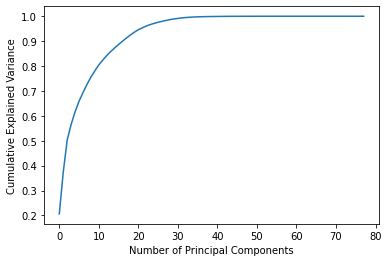

In [15]:
pca_test = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Now fitting and transforming the data with PCA

Thus, the optimal number of principle components is set to the environment variable and this is now used to produce the appropriate multi-dimensional principle component array. This will be formatted back to a Pandas dataframe afterwards.

References: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html and https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [16]:
pca = PCA(n_components=dimensions_num_for_PCA)
principal_components = pca.fit(df_scaled).transform(df_scaled)
principal_components

array([[ 4.09274929e+00, -1.03935146e+00,  1.26069052e+00, ...,
         4.05336204e-02,  1.06574237e+00, -2.21164772e-01],
       [ 4.44413610e+00, -9.90881808e-01,  7.66886528e-01, ...,
         2.40953745e-02,  1.56627205e+00,  5.01799885e-01],
       [ 4.18433641e+00, -6.83524722e-01,  8.51537189e-03, ...,
        -2.57007647e-01, -1.82334181e+00, -1.03678262e-03],
       ...,
       [-1.41932208e+00,  3.17637366e-01,  8.22303595e-02, ...,
        -1.62401809e-02,  7.54705563e-02,  1.69020295e-01],
       [-1.64998846e+00,  2.66933665e-01,  4.67961193e-01, ...,
         5.60165904e-03, -2.05599506e-01, -2.95715483e-01],
       [-1.67577535e+00,  2.66191192e-01,  4.96849568e-01, ...,
         4.02769175e-02, -9.89530797e-02, -1.37579419e-01]])

Getting the Principal Component feature names, dynamically, for the optimal number of components (passed in as a param).

In [17]:
# See Methods at the top of the notebook
principal_component_headings = get_PCA_feature_names(dimensions_num_for_PCA)

Turning the Principal Components back into a Pandas Dataframe, ready for concatting back with the **label** feature.

In [18]:
df_pc = pd.DataFrame(data = principal_components, columns = principal_component_headings)
df_pc

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10,...,Principal component 21,Principal component 22,Principal component 23,Principal component 24,Principal component 25,Principal component 26,Principal component 27,Principal component 28,Principal component 29,Principal component 30
0,4.092749,-1.039351,1.260691,-4.038849,1.985634,1.064285,0.626387,-4.319053,-0.378186,-2.292077,...,0.442761,-0.674434,0.700384,0.538268,-0.173432,-0.348808,-1.069114,0.040534,1.065742,-0.221165
1,4.444136,-0.990882,0.766887,-2.737491,1.758523,1.036710,1.748314,-4.440705,-0.321942,-2.087103,...,-0.161841,-2.012189,2.037390,-0.565709,-1.112169,-0.363729,-1.425324,0.024095,1.566272,0.501800
2,4.184336,-0.683525,0.008515,-4.374319,-0.862230,18.046185,2.732318,4.997712,0.845690,-1.541559,...,-1.289033,0.236197,-0.113712,-0.441430,0.408279,1.302977,-0.906553,-0.257008,-1.823342,-0.001037
3,-1.713239,0.312049,0.565426,0.083323,-0.084603,0.206758,-0.418716,-0.327378,-0.026131,-0.799707,...,0.272844,-0.637691,-0.992782,0.698782,-0.016019,0.183645,0.195657,-0.208603,0.041691,-0.588364
4,-1.653736,0.194937,0.633811,-0.673525,-0.474191,0.111487,-0.577059,-0.013320,0.094306,-0.967332,...,-0.063274,-0.020065,0.383190,0.180168,0.378840,0.077930,0.169476,-0.092612,0.160256,-0.325747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,-1.354979,0.294521,0.096545,1.349656,0.014952,0.248632,0.582599,-0.536717,0.049130,-0.606542,...,0.096936,-1.160574,0.345408,-0.166113,-0.641177,0.143569,0.115087,-0.283245,0.156974,-0.168432
190907,-1.517663,0.304064,0.216418,1.565045,-0.019931,0.317247,0.311972,-0.303801,-0.008274,0.138634,...,-0.273440,-0.281598,-0.072978,-0.002141,-0.048658,0.023680,-0.054482,-0.003589,0.037226,0.090318
190908,-1.419322,0.317637,0.082230,1.903840,0.017500,0.323318,0.545954,-0.360911,-0.001133,0.171949,...,-0.313809,-0.466276,0.120292,-0.185041,-0.201036,0.023039,-0.080849,-0.016240,0.075471,0.169020
190909,-1.649988,0.266934,0.467961,1.250169,0.159151,0.432371,-0.073269,-0.330663,0.011988,-0.088190,...,0.036056,0.638537,-0.087614,0.225365,0.481676,0.015481,0.191181,0.005602,-0.205600,-0.295715


Joining/ concatinating the label feature back onto the pca transformed dataset. Label still needs to be transformed into binary data (for model comprehension/ understanding i.e. the model doesn't understand string data but string data can be transformed into numeric data, which is model can understand and use).

In [19]:
df_final = pd.concat([df_pc, df_labels], axis = 1)
# Scroll to the RHS end of dataframe to see attached label feature
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10,...,Principal component 22,Principal component 23,Principal component 24,Principal component 25,Principal component 26,Principal component 27,Principal component 28,Principal component 29,Principal component 30,label
0,4.092749,-1.039351,1.260691,-4.038849,1.985634,1.064285,0.626387,-4.319053,-0.378186,-2.292077,...,-0.674434,0.700384,0.538268,-0.173432,-0.348808,-1.069114,0.040534,1.065742,-0.221165,BENIGN
1,4.444136,-0.990882,0.766887,-2.737491,1.758523,1.036710,1.748314,-4.440705,-0.321942,-2.087103,...,-2.012189,2.037390,-0.565709,-1.112169,-0.363729,-1.425324,0.024095,1.566272,0.501800,BENIGN
2,4.184336,-0.683525,0.008515,-4.374319,-0.862230,18.046185,2.732318,4.997712,0.845690,-1.541559,...,0.236197,-0.113712,-0.441430,0.408279,1.302977,-0.906553,-0.257008,-1.823342,-0.001037,BENIGN
3,-1.713239,0.312049,0.565426,0.083323,-0.084603,0.206758,-0.418716,-0.327378,-0.026131,-0.799707,...,-0.637691,-0.992782,0.698782,-0.016019,0.183645,0.195657,-0.208603,0.041691,-0.588364,BENIGN
4,-1.653736,0.194937,0.633811,-0.673525,-0.474191,0.111487,-0.577059,-0.013320,0.094306,-0.967332,...,-0.020065,0.383190,0.180168,0.378840,0.077930,0.169476,-0.092612,0.160256,-0.325747,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,-1.354979,0.294521,0.096545,1.349656,0.014952,0.248632,0.582599,-0.536717,0.049130,-0.606542,...,-1.160574,0.345408,-0.166113,-0.641177,0.143569,0.115087,-0.283245,0.156974,-0.168432,BENIGN
190907,-1.517663,0.304064,0.216418,1.565045,-0.019931,0.317247,0.311972,-0.303801,-0.008274,0.138634,...,-0.281598,-0.072978,-0.002141,-0.048658,0.023680,-0.054482,-0.003589,0.037226,0.090318,BENIGN
190908,-1.419322,0.317637,0.082230,1.903840,0.017500,0.323318,0.545954,-0.360911,-0.001133,0.171949,...,-0.466276,0.120292,-0.185041,-0.201036,0.023039,-0.080849,-0.016240,0.075471,0.169020,BENIGN
190909,-1.649988,0.266934,0.467961,1.250169,0.159151,0.432371,-0.073269,-0.330663,0.011988,-0.088190,...,0.638537,-0.087614,0.225365,0.481676,0.015481,0.191181,0.005602,-0.205600,-0.295715,BENIGN


### Transforming the label feature's categorical data into numeric data (via LabelBinarizer)

Again, a model can't understand e.g. 'yes' and 'no' strings but, these can be mapped to a 1 for yes and a 0 for no.

The **sklearn.preprocessing.LabelBinarizer** can be used to convert the column data into binary numbers, which will then be correctly interpreted.

1. Fit the List- this tells the LabelBinarizer what values exist, and how to map them. 

2. Call transform, passing a List, and this will return the encoded List.

**(Note: if label column has more than 2 unique labels, pandas.get_dummies is required instead)**

(Code reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)

In [20]:
lb = LabelBinarizer()
df_final['label'] = lb.fit_transform(df_final['label'])
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10,...,Principal component 22,Principal component 23,Principal component 24,Principal component 25,Principal component 26,Principal component 27,Principal component 28,Principal component 29,Principal component 30,label
0,4.092749,-1.039351,1.260691,-4.038849,1.985634,1.064285,0.626387,-4.319053,-0.378186,-2.292077,...,-0.674434,0.700384,0.538268,-0.173432,-0.348808,-1.069114,0.040534,1.065742,-0.221165,0
1,4.444136,-0.990882,0.766887,-2.737491,1.758523,1.036710,1.748314,-4.440705,-0.321942,-2.087103,...,-2.012189,2.037390,-0.565709,-1.112169,-0.363729,-1.425324,0.024095,1.566272,0.501800,0
2,4.184336,-0.683525,0.008515,-4.374319,-0.862230,18.046185,2.732318,4.997712,0.845690,-1.541559,...,0.236197,-0.113712,-0.441430,0.408279,1.302977,-0.906553,-0.257008,-1.823342,-0.001037,0
3,-1.713239,0.312049,0.565426,0.083323,-0.084603,0.206758,-0.418716,-0.327378,-0.026131,-0.799707,...,-0.637691,-0.992782,0.698782,-0.016019,0.183645,0.195657,-0.208603,0.041691,-0.588364,0
4,-1.653736,0.194937,0.633811,-0.673525,-0.474191,0.111487,-0.577059,-0.013320,0.094306,-0.967332,...,-0.020065,0.383190,0.180168,0.378840,0.077930,0.169476,-0.092612,0.160256,-0.325747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,-1.354979,0.294521,0.096545,1.349656,0.014952,0.248632,0.582599,-0.536717,0.049130,-0.606542,...,-1.160574,0.345408,-0.166113,-0.641177,0.143569,0.115087,-0.283245,0.156974,-0.168432,0
190907,-1.517663,0.304064,0.216418,1.565045,-0.019931,0.317247,0.311972,-0.303801,-0.008274,0.138634,...,-0.281598,-0.072978,-0.002141,-0.048658,0.023680,-0.054482,-0.003589,0.037226,0.090318,0
190908,-1.419322,0.317637,0.082230,1.903840,0.017500,0.323318,0.545954,-0.360911,-0.001133,0.171949,...,-0.466276,0.120292,-0.185041,-0.201036,0.023039,-0.080849,-0.016240,0.075471,0.169020,0
190909,-1.649988,0.266934,0.467961,1.250169,0.159151,0.432371,-0.073269,-0.330663,0.011988,-0.088190,...,0.638537,-0.087614,0.225365,0.481676,0.015481,0.191181,0.005602,-0.205600,-0.295715,0


Showing the transformation. **Again, to note, if label isn't binary then pd.get_dummies is required.**

In [21]:
print("Before LabelBinarizer: ", df_labels.unique())
print("After LabelBinarizer: ", df_final['label'].unique())

Before LabelBinarizer:  ['BENIGN' 'Bot']
After LabelBinarizer:  [0 1]


#### The data is now fully cleaned and transformed, ready for pre-modeling test_train data splitting

## K-Fold Cross Validation and Stratified splitting
K-Fold is a technique which splits data into K folds (splits). Train of a model K times, and for each training iteration, K-Fold selects a different fold to use for testing; the remaining K - 1 folds become the training data. Typically, the optimal K value can be derived using the size of your dataset (num of rows). Ideally, each fold should be statistically representative of the population. Too small and it won't be useful. Too large, and you lose the positives from doing K-Fold.

You can use Stratified splitting with K-Fold, which ensures balance between some criteria (balances out the classes) e.g. equal portion of label classes in each fold.

Class Imbalance is a significant issue in the ML/ Data Mining domain. It leads to incorrect results e.g. if one fold had all of 1 label (accidentally), then it would produce terrible predictive results as it wouldn't know what the other label class data point would look like. You can only work with the data you have, so this has to be dealt with.

Benefits of K-Fold:
- Use more of the data towards making a succesful model.
- Obtain K models to evaluate, can improve the confidence that you have selected an appropriate model algorithm and cleaned/ prepared the data correctly, e.g. normal split with 1 model, one doesn't know if it's good or not- it could be heavily biased. Multiple models ensures less bias and increased variance.
- Looking at the accuracy results from each of the k-Folds, you can identify data issues e.g. a certain fold performs really badly. Could this suggest that more cleaning is required? Maybe the data preparation was performed incorrectly?
- If all folds return similar accuracies, one can be more confident that a deployed model will perform similarly to how one expects.

Issues with K-Fold:
- Creating K separate models requires more computation.
- If you haven't got much data, you might not get many folds. Less folds means K-Fold loses its benefits.
- If K is very large, each fold is small, and harder to ensure statistical distribution of.
- Choosing the best of K models introduces bias. Real world data could perform better under a more general, lower performing model.

Code reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [22]:
# Separating the label so that the answers aren't provided to the model, in training.
X = df_final.drop(['label'], axis = 1)
y = df_final['label']
y

0         0
1         0
2         0
3         0
4         0
         ..
190906    0
190907    0
190908    0
190909    0
190910    0
Name: label, Length: 190911, dtype: int64

Initialising the StratifiedKFold model (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

In [23]:
skf = StratifiedKFold(n_splits=num_of_splits_for_skf, shuffle=False)
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

Now, splitting the data into train and test data, using the optimal splitting techniques of K-Fold and Stratified Splitting.

In [24]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
    
print( 'X_train length: ', len(X_train) ) # To check if splits worked
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  171820
y_train length:  171820
X_test length:  19091
y_test length:  19091


## Modeling stage
Data is now fully transformed and ready for ML model training and predictions

### K-Nearest neighbor ML classifier
The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are assumed to be near to each other.

The most important factor in training a KNN model is the **number of neighbors hyperparameter**. You want to choose the K  value that reduces the number of errors, while maintaining the algorithm’s ability to accurately make predictions when it’s given data it hasn’t seen before. Here are some important considerations:

- As you decrease the value of K to **1**, predictions become less stable e.g. imagine K=1 and you have a query point surrounded by several red 'dots' and one green 'dot', but the green dot is the single nearest neighbor. Reasonably, you would think the query point is most likely red, but because K=1, KNN incorrectly predicts that the query point is green.

- Inversely, as you increase the value of K, predictions become more stable due to majority voting/ averaging, and thus, more likely to make more accurate predictions (up to a certain critical point- an **'overfitting' threshold**). Eventually, you would begin to witness an increasing number of errors. It is at this point you'd know that you have pushed the value of K too far.

- In cases where you are taking a majority vote (e.g. picking the mode in a classification problem) amongst labels/ classes, you usually make K an odd number to have a tiebreaker.

The sklearn's default k value is 5 (also true for MATLAB's implementation).

References: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html & https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

In [25]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

### Training the model and predicting test data results (confusion matrix)
The selected Machine Learning classifier/ model/ models can now be trained on training data (from the StratifiedKFold splitting). Once the model is trained, it can be used to predict the test data's labels (based upon what it has seen before).

The performance of the model can be seen below in the Classification Report, Confusion Matrix, and the model's predicitive accuracy result.

(see **methods** section, at the top of the notebook, for the train_model_predict() method code. Note that it can take a few minutes to run due to the vast amount of data used, and the training time required for the model to learn).

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18895
           1       0.86      1.00      0.92       196

    accuracy                           1.00     19091
   macro avg       0.93      1.00      0.96     19091
weighted avg       1.00      1.00      1.00     19091
 

Model accuracy=  99.8271436802682 %


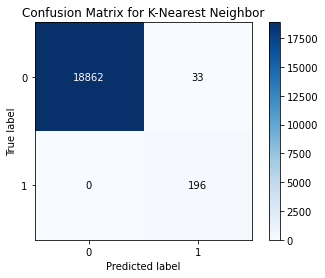

In [26]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(knn_model, "K-Nearest Neighbor", X, y, skf)
print("Model accuracy= ", accuracy*100, "%")

## The SafeML statistical distance measures: test/ example run
Now the ML models have been run, and the accuracy is found (along with other useful performance metrics), a test run of using the SafeML statistical distance measures can be run. This is a test run, and the real run will be done later. This test run is a guided 'tour' around how to set-up the code, in Python and SciKit-Learn, so that results can be re-produced easily for future case-studies or projects.

In [27]:
# Extracting the number of classes and labels from the label feature
class_num = len(df_final['label'].unique())
labels = df_final['label'].unique()
print("Number of classes: ", class_num)
print("Labels: ", labels)

Number of classes:  2
Labels:  [0 1]


In [28]:
X_train

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10,...,Principal component 21,Principal component 22,Principal component 23,Principal component 24,Principal component 25,Principal component 26,Principal component 27,Principal component 28,Principal component 29,Principal component 30
0,4.092749,-1.039351,1.260691,-4.038849,1.985634,1.064285,0.626387,-4.319053,-0.378186,-2.292077,...,0.442761,-0.674434,0.700384,0.538268,-0.173432,-0.348808,-1.069114,0.040534,1.065742,-0.221165
1,4.444136,-0.990882,0.766887,-2.737491,1.758523,1.036710,1.748314,-4.440705,-0.321942,-2.087103,...,-0.161841,-2.012189,2.037390,-0.565709,-1.112169,-0.363729,-1.425324,0.024095,1.566272,0.501800
2,4.184336,-0.683525,0.008515,-4.374319,-0.862230,18.046185,2.732318,4.997712,0.845690,-1.541559,...,-1.289033,0.236197,-0.113712,-0.441430,0.408279,1.302977,-0.906553,-0.257008,-1.823342,-0.001037
3,-1.713239,0.312049,0.565426,0.083323,-0.084603,0.206758,-0.418716,-0.327378,-0.026131,-0.799707,...,0.272844,-0.637691,-0.992782,0.698782,-0.016019,0.183645,0.195657,-0.208603,0.041691,-0.588364
4,-1.653736,0.194937,0.633811,-0.673525,-0.474191,0.111487,-0.577059,-0.013320,0.094306,-0.967332,...,-0.063274,-0.020065,0.383190,0.180168,0.378840,0.077930,0.169476,-0.092612,0.160256,-0.325747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180458,-1.309732,0.163678,0.269997,-0.301117,-0.877977,-0.022937,-1.058550,0.221214,-0.038836,-0.652436,...,-0.217063,0.859949,-0.616744,-0.641489,0.423233,0.424507,0.172662,0.181614,0.738116,0.014353
180459,-1.309538,0.163464,0.270769,-0.300558,-0.877276,-0.023715,-1.058222,0.223174,-0.038801,-0.653191,...,-0.216391,0.859942,-0.616294,-0.641450,0.423682,0.425169,0.172423,0.181048,0.738087,0.014523
180460,-1.310430,0.163905,0.270045,-0.300560,-0.877339,-0.023643,-1.058168,0.223168,-0.038803,-0.653154,...,-0.216426,0.859966,-0.616254,-0.641398,0.423837,0.425360,0.172421,0.180635,0.738085,0.014608
180498,-1.306906,0.162115,0.273153,-0.300319,-0.876812,-0.024225,-1.058242,0.223964,-0.038788,-0.653538,...,-0.215993,0.859884,-0.616220,-0.641597,0.423400,0.424800,0.172352,0.181976,0.738110,0.014327


Pre-finished code using just the first label in the labels array. Selects all the relevant rows/ data points. 

- df.loc[] method can be used to locate certain rows based upon the query passed into the square brackets[].

In [29]:
# x1 = X_test[np.where(np.asarray(y_train).reshape(-1, 1).ravel() == labels[0])]
# X_train_L = X_train.iloc[np.where(y_train[:,1] == 1)]
X_train_L = X_train.loc[y_train == labels[0]]
X_train_L

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10,...,Principal component 21,Principal component 22,Principal component 23,Principal component 24,Principal component 25,Principal component 26,Principal component 27,Principal component 28,Principal component 29,Principal component 30
0,4.092749,-1.039351,1.260691,-4.038849,1.985634,1.064285,0.626387,-4.319053,-0.378186,-2.292077,...,0.442761,-0.674434,0.700384,0.538268,-0.173432,-0.348808,-1.069114,0.040534,1.065742,-0.221165
1,4.444136,-0.990882,0.766887,-2.737491,1.758523,1.036710,1.748314,-4.440705,-0.321942,-2.087103,...,-0.161841,-2.012189,2.037390,-0.565709,-1.112169,-0.363729,-1.425324,0.024095,1.566272,0.501800
2,4.184336,-0.683525,0.008515,-4.374319,-0.862230,18.046185,2.732318,4.997712,0.845690,-1.541559,...,-1.289033,0.236197,-0.113712,-0.441430,0.408279,1.302977,-0.906553,-0.257008,-1.823342,-0.001037
3,-1.713239,0.312049,0.565426,0.083323,-0.084603,0.206758,-0.418716,-0.327378,-0.026131,-0.799707,...,0.272844,-0.637691,-0.992782,0.698782,-0.016019,0.183645,0.195657,-0.208603,0.041691,-0.588364
4,-1.653736,0.194937,0.633811,-0.673525,-0.474191,0.111487,-0.577059,-0.013320,0.094306,-0.967332,...,-0.063274,-0.020065,0.383190,0.180168,0.378840,0.077930,0.169476,-0.092612,0.160256,-0.325747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171738,-2.080635,0.281920,0.917342,-1.160169,-0.283203,0.004132,-1.517045,1.134613,-0.000422,0.947635,...,0.355567,0.922128,0.944757,0.926720,-1.245846,0.223691,-0.311228,-0.197733,0.156889,-0.096722
171739,-1.988899,0.292872,0.770566,-2.050039,0.178067,-0.284153,-0.720700,0.551885,0.011976,0.059235,...,0.427968,-1.417568,-0.826078,-0.735086,1.149698,-0.323733,0.229033,0.119760,-0.298181,0.141480
171740,-2.286003,0.326393,1.031072,-2.154463,0.082432,-0.304836,-1.476853,1.601041,-0.002130,2.050197,...,0.566127,0.181841,0.065557,-0.939717,-0.071471,0.359359,0.403155,0.073381,0.043813,-0.215638
171741,-2.288205,0.326853,1.032382,-2.163379,0.087006,-0.308509,-1.469079,1.604203,-0.001871,2.074340,...,0.573426,0.172568,0.060751,-0.939130,-0.072575,0.359498,0.403008,0.072601,0.044451,-0.216689


Pre-finished code using just the first label in the labels array. Selects all the relevant rows/ data points.

In [30]:
X_test_L = X_test.loc[pred_y == labels[0]]
X_test_L

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10,...,Principal component 21,Principal component 22,Principal component 23,Principal component 24,Principal component 25,Principal component 26,Principal component 27,Principal component 28,Principal component 29,Principal component 30
171745,-2.303129,0.361628,0.947852,-3.620681,1.067760,-0.965932,1.098259,0.684323,0.061317,3.117149,...,0.628069,-1.895014,-0.954208,-0.657958,0.854606,-0.246395,0.128871,0.073815,-0.186069,0.085861
171746,-2.327750,0.334694,1.057779,-2.300704,0.164222,-0.363147,-1.342109,1.652518,0.003006,2.466938,...,0.675268,0.017202,-0.042131,-0.922967,-0.097237,0.372179,0.395776,0.057406,0.055095,-0.231572
171747,-1.648880,0.266311,0.469178,1.250193,0.159521,0.431733,-0.073524,-0.329310,0.012102,-0.091711,...,0.034353,0.638336,-0.088737,0.225347,0.482053,0.015635,0.190969,0.005160,-0.205524,-0.295392
171748,12.481084,-3.616323,0.451260,-2.301646,-0.770633,1.066906,-2.625990,-5.464694,-0.555513,1.549606,...,-0.789315,-0.557111,-0.165775,-0.372385,-0.448510,-0.547764,0.114492,-1.602567,-0.241119,-0.255728
171749,-1.459016,0.309033,0.141391,2.051974,0.169310,0.410693,0.461944,-0.464321,-0.010347,0.050964,...,-0.134433,-0.168244,-0.045204,-0.026509,-0.100042,0.032717,0.003517,-0.046756,-0.057856,-0.034660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,-1.354979,0.294521,0.096545,1.349656,0.014952,0.248632,0.582599,-0.536717,0.049130,-0.606542,...,0.096936,-1.160574,0.345408,-0.166113,-0.641177,0.143569,0.115087,-0.283245,0.156974,-0.168432
190907,-1.517663,0.304064,0.216418,1.565045,-0.019931,0.317247,0.311972,-0.303801,-0.008274,0.138634,...,-0.273440,-0.281598,-0.072978,-0.002141,-0.048658,0.023680,-0.054482,-0.003589,0.037226,0.090318
190908,-1.419322,0.317637,0.082230,1.903840,0.017500,0.323318,0.545954,-0.360911,-0.001133,0.171949,...,-0.313809,-0.466276,0.120292,-0.185041,-0.201036,0.023039,-0.080849,-0.016240,0.075471,0.169020
190909,-1.649988,0.266934,0.467961,1.250169,0.159151,0.432371,-0.073269,-0.330663,0.011988,-0.088190,...,0.036056,0.638537,-0.087614,0.225365,0.481676,0.015481,0.191181,0.005602,-0.205600,-0.295715


### Running the Statistical distance measure algorithms
This is just a preliminary run to show an example of how to use the methods.

In [31]:
num_of_features = len(X_train_L.columns)
num_of_features

30

Running the statistical measure (univariate version) methods from the local Python modules defined in the project folder.

Because the Python methods are slightly different to the current MATLAB versions, one has to pass in a feature 1 at a time (univariate). Then, after all the features have been passed in and sent back, this means the full dataset has been used to calculate the various ECDF-based statistical distance measures. This is what is displayed in the plotting of results section below.

In [32]:
CVM_distances = np.zeros(num_of_features)
Anderson_Darling_distances = np.zeros(num_of_features)
Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
Kuiper_distances = np.zeros(num_of_features)
Wasserstein_distances = np.zeros(num_of_features)
DTS_distances = np.zeros(num_of_features)

for i in range(0, num_of_features):
    # iloc[:, i] allows selection of the ith feature in the Pandas dataframe 
    CVM_distances[i] = Cramer_Von_Mises_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Kuiper_distances[i] = Kuiper_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Wasserstein_distances[i] = Wasserstein_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    DTS_distances[i] = DTS_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    
print(" Cramer Von Mises distances: ", CVM_distances)
print("\n Anderson Darling distances: ", Anderson_Darling_distances)
print("\n Kolmogorov Smirnov distances: ", Kolmogorov_Smirnov_distances)
print("\n Kuiper distances: ", Kuiper_distances)
print("\n Wasserstein distances: ", Wasserstein_distances)
print("\n DTS distances: ", DTS_distances)

 Cramer Von Mises distances:  [4931.06913973 1880.22609555 2637.74853648 3887.08189088 2817.73400374
 1228.99862326 5326.72344433 1441.84903199 5581.9304574  1870.07340615
 2519.32470931 1750.8082772  2960.96771103 2652.20239772 2528.64404831
 2096.51552976 3333.99816795 2706.48495659 2372.50233069 5436.64931689
 3777.57495035 4925.00252582 5050.56161273 5449.59664843 2873.31023483
 3181.46095623 2522.44419938 3196.61503693 6118.89177346 1681.43774696]

 Anderson Darling distances:  [26.75836521 13.96957615 15.04432319 21.44928371 16.33276503  8.07662147
 27.73575527  8.61158416 29.58329696 11.35074387 12.95107542 10.54389511
 16.26973466 15.61034957 15.15529759 11.06755426 18.73245964 15.46430099
 14.29728255 26.96297443 20.03427739 26.87518677 26.36601908 29.07657652
 15.61414686 16.30856267 15.81665662 17.54938689 32.84830419  9.74571338]

 Kolmogorov Smirnov distances:  [0.06031173 0.02489308 0.03294141 0.04644905 0.03471953 0.02084796
 0.06044592 0.0279256  0.05558753 0.02576305 0

### Plotting the test/ example results
This shows the varying distances of each statistical distance measure, between **each feature only**, in a single dataset split (1 permutation). Therefore, it is only an example and not representative of the real run (like a CRISP-DM cycle run through, where one can evaluate and re-run after).

The real run will plot the distances between all the features (entire dataset) of each dataset split (Permutation) against the average accuracy from all permutations. Thus, showing how statistical distances can be used to estimate the accuracy of models (the SafeML idea).

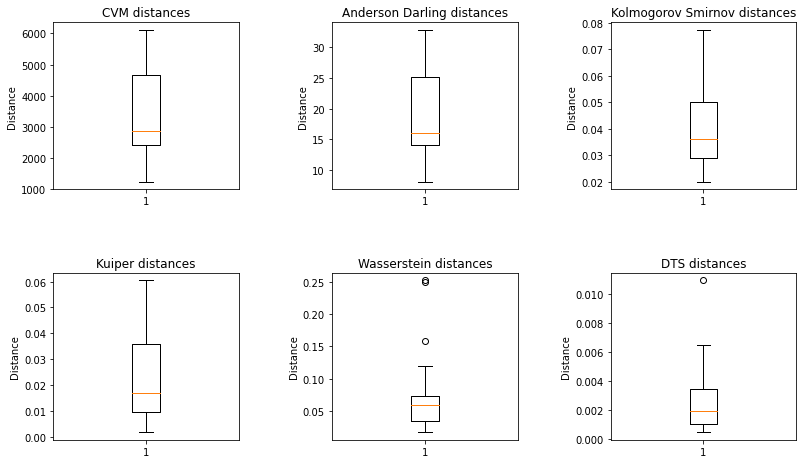

In [83]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].boxplot(CVM_distances)
axs[0, 0].set_title('CVM distances')
axs[0, 0].set_ylabel("Distance")

axs[0, 1].boxplot(Anderson_Darling_distances)
axs[0, 1].set_title('Anderson Darling distances')
axs[0, 1].set_ylabel("Distance")

axs[0, 2].boxplot(Kolmogorov_Smirnov_distances)
axs[0, 2].set_title('Kolmogorov Smirnov distances')
axs[0, 2].set_ylabel("Distance")

axs[1, 0].boxplot(Kuiper_distances)
axs[1, 0].set_title("Kuiper distances")
axs[1, 0].set_ylabel("Distance")

axs[1, 1].boxplot(Wasserstein_distances)
axs[1, 1].set_title("Wasserstein distances")
axs[1, 1].set_ylabel("Distance")

axs[1, 2].boxplot(DTS_distances)
axs[1, 2].set_title("DTS distances")
axs[1, 2].set_ylabel("Distance")

fig.subplots_adjust(left=0.08, right=1.8, bottom=0.05, top=1.5, hspace=0.5, wspace=0.5)

plt.show()

# Starting the real run, using the PCA-transformed dataset
The dataset shown below is the PCA-transformed data, with the label/ class feature attached (which has been LabelBinarized, into numbers from class names- so the model can understand).

To simulate the SafeML idea, a number of permutations have to be run. Each permutation will have its data split differently, and this results in varying model accuracies (different data => different accuracies). The hope (for the simulation) is that as these accuracies vary between permutations, the statistical difference values vary along with it- in a highly (positive) correlated way. This would show that ECDF-based statistical distance measures can actually be used to predict model performance. The final graphing/ plotting will show these relationships, so the correlation can be easily identified. A case-study for this dataset has been run in MATLAB, but not Python. The aim of this file is to have a Python code case-study for the same dataset, and verify the results to see if they match/ are similar to the MATLAB implementation. If it matches, then this case-study can be confidently merged into the master branch, of the SafeML repository.

In [84]:
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10,...,Principal component 22,Principal component 23,Principal component 24,Principal component 25,Principal component 26,Principal component 27,Principal component 28,Principal component 29,Principal component 30,label
0,4.092749,-1.039351,1.260691,-4.038849,1.985634,1.064285,0.626387,-4.319053,-0.378186,-2.292077,...,-0.674434,0.700384,0.538268,-0.173432,-0.348808,-1.069114,0.040534,1.065742,-0.221165,0
1,4.444136,-0.990882,0.766887,-2.737491,1.758523,1.036710,1.748314,-4.440705,-0.321942,-2.087103,...,-2.012189,2.037390,-0.565709,-1.112169,-0.363729,-1.425324,0.024095,1.566272,0.501800,0
2,4.184336,-0.683525,0.008515,-4.374319,-0.862230,18.046185,2.732318,4.997712,0.845690,-1.541559,...,0.236197,-0.113712,-0.441430,0.408279,1.302977,-0.906553,-0.257008,-1.823342,-0.001037,0
3,-1.713239,0.312049,0.565426,0.083323,-0.084603,0.206758,-0.418716,-0.327378,-0.026131,-0.799707,...,-0.637691,-0.992782,0.698782,-0.016019,0.183645,0.195657,-0.208603,0.041691,-0.588364,0
4,-1.653736,0.194937,0.633811,-0.673525,-0.474191,0.111487,-0.577059,-0.013320,0.094306,-0.967332,...,-0.020065,0.383190,0.180168,0.378840,0.077930,0.169476,-0.092612,0.160256,-0.325747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,-1.354979,0.294521,0.096545,1.349656,0.014952,0.248632,0.582599,-0.536717,0.049130,-0.606542,...,-1.160574,0.345408,-0.166113,-0.641177,0.143569,0.115087,-0.283245,0.156974,-0.168432,0
190907,-1.517663,0.304064,0.216418,1.565045,-0.019931,0.317247,0.311972,-0.303801,-0.008274,0.138634,...,-0.281598,-0.072978,-0.002141,-0.048658,0.023680,-0.054482,-0.003589,0.037226,0.090318,0
190908,-1.419322,0.317637,0.082230,1.903840,0.017500,0.323318,0.545954,-0.360911,-0.001133,0.171949,...,-0.466276,0.120292,-0.185041,-0.201036,0.023039,-0.080849,-0.016240,0.075471,0.169020,0
190909,-1.649988,0.266934,0.467961,1.250169,0.159151,0.432371,-0.073269,-0.330663,0.011988,-0.088190,...,0.638537,-0.087614,0.225365,0.481676,0.015481,0.191181,0.005602,-0.205600,-0.295715,0


## Starting the main loop and all other required loops (for permutations)
The permutation number is instantiated at the top of the notebook, in the environment variables section. This allows the number of permutations to be easily changed.

IMPORTANT NOTE: A **for loop** in one Jupyter Notebook cell cannot be extended past a single cell. This is bad for documentation purposes because markdown cells cannot be inserted between cells as this would cause the **for loop** to become out of scope for other cells. Therefore, a highly modulated approach must be taken, where everything is put into a function/ method. This allows markdown cells to exist above a section of code/ method so it can be explained/ documented. Code comments will be used when necessary too.

In [86]:
# 1st Set all variables needed outside for loop scope, e.g. the multi-dimensional Results array.
# Results(row, column, page) in matlab. results(row, column, depth) in Python/ numpy.
#results = [[],[],[]]

#number_of_classes = len(df_final['label'].unique())

#results = numpy.zeros((number_of_classes, ,k))
#for current_permutation in range(number_of_permutations):
    # 1.1. Cross validation, train test splitting here (extract to functions)
    # 1.2. Train classifiers here using the train and test data. 'classifiers' variable name to be used.
    # 1.3. Extract unique labels here, for next loop
    #for current_classifier in range(classifiers):
        # 2.1. Run model.predict for current_classifier.
        # 2.2. Using the pred_y, get the confusion matrix or classification report for this.
        # 2.3. Use the num of unique labels variable or set new one (for num of classes), for next loop
        #for current_label in range(labels.size or classNum.size or .length):
            # 3.1. Get train and test rows with matching current_label/ class (via .loc)
            # 3.2. Using the multi-dim Results array, save the model accuracy of that specific...
            # ... permutation, by using the pred_y and Y_Test in previous loop. Save to the ...
            # ... Results(current_label, 1, current_permutation) index (of multi-dim array)
            # 3.3. Use train and test rows (matching current_label) and pass into statistical distance methods ...
            # ... They're Univariate methods (in Python) so be careful to use them correctly like examples above.
            # 3.4. Save each stastical distance measure result to Results(current_label, x, current_permutation) ...
            # ... where x is an int for each statistical distance result to save.
            # 3.5. END the current_label for loop
        # 2.4. After for loop above is finished, plot the accuracies via MatPlotLib. Koorosh sorts the results ...
        # ... first for some reason. May not need to but this is to be decided.
        # 2.5. END the current_classifier for loop
    # 1.4. END the current_permutation for loop (loop is finished)
    
# Finally, boxplot the results ontop of the current accuracy graph/ plot. Then, show the final plots.
# Koorosh uses the number of classes for this, to iterate over them, so may need this.
        

## Skipping above implementation to try something simpler and better hopefully
Instead of a 3D array, just use 1 classifier at a time and then have a 2D array (or Pandas DataFrame for easy plotting later) where each row is a permutation and each column has: the model's accuracy in 1st column, then each subsequent statistical distance measure to be used in the later columns.

Then, one can graph a line graph/ Seaborn displot of the accuracy on the x-axis vs the specific statistical distance measure on the y-axis. Therefore resulting in 6 plots/ graphs, 1 for each ECDF statistical distance measure.

Each class will represent a line on the graph (differentiated via hue colouring) or by having separate plots for each class/ label.

NOTE: Could also store F1-Score, Sensitivity score, Precision score, etc...?

In [88]:
# Firstly, creating the final 2D-array (Pandas Dataframe) which will be used to store the Results
# PRESERVE THE ORDERING
results_column_names = ['Accuracy', 'Anderson_Darling_dist', 'CVM_dist',
                                     'DTS_dist', 'Kolmogorov_Smirnov_dist','Kuiper_dist', 'Wasserstein_dist']
# Creating the empty Dataframe for Results
df_results = pd.DataFrame(columns = results_column_names)
# Can copy this dataframe for future results tables e.g. for each class/ label
df_results

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist


## Code for each permutation
Now, running the code for each permutation requires StratifiedKFold splitting, model training and predicting classes via the chosen classifier, and finally the iteration over each class/ label to calculate the statistical distance. Then, once complete, the results table can be used to plot the results from all the permutations.

**Quick note on terminology:** The terminology 'class' and 'label' is used interchangeably throughout the industry, but both mean the same things. They represent the different possible answers the dataset holds and/ or the model can output e.g. a dataset (for supervised learning i.e. given the answers to train with) with a person's personal data may have 2 classes/ labels (answers). Either Male or Female. Male is 1 class/ label, and Female is 1 class/ label. The number of classes in the dataset would be 2. Also, a model would only be able to predict and output 2 different options/ results.

In [ ]:
# 1st Set all variables needed outside for loop scope, e.g. the multi-dimensional Results array.
labels = df_final['label'].unique()
number_of_classes = len(df_final['label'].unique())
# List of Lists to hold each separate label result, using list_index->label_number mapping (for accessing)
# Using Python 'List Comprehensions'. This way is Python sub-list ID safe, see link for more info:
# https://thispointer.com/how-to-create-and-initialize-a-list-of-lists-in-python/
list_of_lists_results = [[] for i in range(number_of_classes)]
# See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.

for current_permutation in range(number_of_permutations):
    # 1.1. Cross validation, train test splitting here (extract to functions)
    X_train, X_test, y_train, y_test = get_stratifiedKFold_train_test_split(X, y)
    
    # 1.2. Train MLP classifier here using the train and test data, and call model.predict to get pred_y
    pred_y, accuracy = train_and_predict_Neural_Network_MLP_model(X_train, X_test, y_train, y_test)
    # TODO: Make an object to add the accuracy, and subsequent statistical dist. measure results
    
    # 1.3. loop over each label/ class to add a new boxplot, or add new hue to plot, or a new plot entirely
    for current_label in range(number_of_classes):
        
        # 1.4. Run the statistical dist measures and save result to Pd.Series obj, to add to results Dataframe
        X_train_loc_for_label, X_test_loc_for_label = get_X_train_and_test_data_for_given_label(labels,
                                                              current_label, X_train, X_test, y_train, y_test)
        
        # 1.5. Get all statistical dist measures for current_label
        dict_result_row = get_statistical_dist_measures_for_class_result(accuracy,
                                                X_train_loc_for_label, X_test_loc_for_label)
        
        # 1.6. Append new dict row to current_label index of list of lists
        # See: https://thispointer.com/how-to-create-and-initialize-a-list-of-lists-in-python/
        list_of_lists_results[current_label].append(dict_result_row)

After all permutations, convert each index (dict list) to a pandas dataframe: //stackoverflow.com/a/17496530

In [ ]:
# After all permutations, convert each index (dict list) to a pandas dataframe: //stackoverflow.com/a/17496530
# Access specific dataframe by index e.g. class 1 dataframe->index 1 mapping
result_dataframes = []

for dict_result_list in list_of_lists_results:
    result_dataframes.append(pd.DataFrame(dict_result_list, columns = results_column_names))

# Print first dataframe result table, for class 0
result_dataframes[0]

Send methods to top

In [ ]:
# send to top and add documentation
def get_statistical_dist_measures_for_class_result(accuracy, X_train_L, X_test_L):
    # Can use this to loop over all the features, since the ECDF Python methods are currently Univariate only
    num_of_features = len(X_train_L.columns)
    
    # Instantiate empty arrays with large enough size, to hold statistical distance data
    CVM_distances = np.zeros(num_of_features)
    Anderson_Darling_distances = np.zeros(num_of_features)
    Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
    Kuiper_distances = np.zeros(num_of_features)
    Wasserstein_distances = np.zeros(num_of_features)
    DTS_distances = np.zeros(num_of_features)

    for i in range(0, num_of_features):
        # iloc[:, i] allows selection of the ith feature in the Pandas dataframe
        # Calling the methods from the imported Python modules (see import section at top of notebook)
        CVM_distances[i] = Cramer_Von_Mises_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Kuiper_distances[i] = Kuiper_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Wasserstein_distances[i] = Wasserstein_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        DTS_distances[i] = DTS_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        
    # Computing mean/ average, to get ECDF distance of full dataset. Float64 to keep accuracy high.
    # See: https://numpy.org/doc/stable/reference/generated/numpy.mean.html
    CVM_distance = np.mean(CVM_distances, dtype=np.float64)
    Anderson_Darling_distance = np.mean(Anderson_Darling_distances, dtype=np.float64)
    Kolmogorov_Smirnov_distance = np.mean(Kolmogorov_Smirnov_distances, dtype=np.float64)
    Kuiper_distance = np.mean(Kuiper_distances, dtype=np.float64)
    Wasserstein_distance = np.mean(Wasserstein_distances, dtype=np.float64)
    DTS_distance = np.mean(DTS_distances, dtype=np.float64)
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Accuracy': accuracy,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [ ]:
# Send to top and add documentation for it
def get_X_train_and_test_data_for_given_label(labels, label_index, X_train, X_test, y_train, y_test):
    X_train_loc_for_label = X_train.loc[y_train == labels[label_index]]
    X_test_loc_for_label = X_test.loc[pred_y == labels[label_index]]
    
    return X_train_loc_for_label, X_test_loc_for_label